In [39]:
pip install bokeh matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 12.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.3 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Range1d, FixedTicker
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.palettes import Category10_10

output_notebook()


Loading BokehJS ...

In [32]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.annotations import Legend

output_notebook()

# Group and prepare data
df = pd.read_csv("myanmar_ch4_plumes.csv")
sector_stats = df.groupby('ipcc_sector')['emission_auto'].agg(['mean', 'sum', 'count']).reset_index()
src = ColumnDataSource(sector_stats)

# Create figure
p = figure(x_range=sector_stats['ipcc_sector'], width=800, height=400,
           title="CH₄ Emissions by Sector", toolbar_location="above")

# Add bars
bars = p.vbar(x='ipcc_sector', top='sum', source=src, width=0.7,
              color='#3498db', legend_label="Total Emissions (kg/hr)")

# Style axes
p.xaxis.major_label_orientation = 0.8
p.yaxis.axis_label = "Total Emissions (kg/hr)"

# Move legend outside
p.legend.location = "top"
p.add_layout(p.legend[0], 'right')  # places legend to the right side
p.legend.label_text_font_size = "10pt"

show(p)


Loading BokehJS ...

In [35]:


df = pd.read_csv("myanmar_ch4_plumes.csv", parse_dates=['datetime'])
df = df.dropna(subset=['datetime', 'emission_auto', 'ipcc_sector']).sort_values('datetime')

# Handle NULL sectors
df['ipcc_sector'] = df['ipcc_sector'].fillna('Unknown')

p = figure(
    width=900, height=500,
    title="CH₄ Emission Rate Timeline by Sector (Annual)",
    x_axis_type='datetime',
    x_axis_label="Year",
    y_axis_label="Emission Rate (kg/hr)"
)

# Set year-only ticks
min_year = int(df['datetime'].dt.year.min())
max_year = int(df['datetime'].dt.year.max()) + 1
p.x_range = Range1d(pd.Timestamp(f"{min_year}-01-01"), pd.Timestamp(f"{max_year}-01-01"))

year_ticks = [pd.Timestamp(y, 1, 1).value / 10**6 for y in range(min_year, max_year + 1)]
p.xaxis.ticker = FixedTicker(ticks=year_ticks)
p.xaxis.formatter = DatetimeTickFormatter(years="%Y")
p.xaxis.minor_tick_line_color = None
p.xgrid.visible = False

palette = Category10_10

# Plot each sector (lines only)
for i, sector in enumerate(sorted(df['ipcc_sector'].unique())):
    data = df[df['ipcc_sector'] == sector].copy()
    src = ColumnDataSource(data)
    color = palette[i % len(palette)]
    p.line('datetime', 'emission_auto', source=src, line_width=3, color=color, legend_label=sector)

# Configure legend
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.legend.title = "Sector"
p.add_layout(p.legend[0], "right")


show(p)


In [36]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Range1d, FixedTicker
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.palettes import Category10_10

output_notebook()

df = pd.read_csv("myanmar_ch4_plumes.csv", parse_dates=['datetime'])
df = df.dropna(subset=['datetime', 'emission_auto', 'ipcc_sector']).sort_values('datetime')
df['ipcc_sector'] = df['ipcc_sector'].fillna('Unknown')

palette = Category10_10

#  Mean emission per sector per month
m = df.copy()
m['month'] = m['datetime'].dt.to_period('M').dt.to_timestamp()
monthly = (m.groupby(['month', 'ipcc_sector'])['emission_auto']
             .mean().reset_index(name='emission'))

p_m = figure(
    width=900, height=500, x_axis_type='datetime',
    title="CH₄ Emission Rate Timeline by Sector — Monthly Average",
    x_axis_label="Year", y_axis_label="Emission Rate (kg/hr)"
)

min_year_m = int(monthly['month'].dt.year.min())
max_year_m = int(monthly['month'].dt.year.max()) + 1
p_m.x_range = Range1d(pd.Timestamp(f"{min_year_m}-01-01"), pd.Timestamp(f"{max_year_m}-01-01"))
year_ticks_m = [pd.Timestamp(y, 1, 1).value / 10**6 for y in range(min_year_m, max_year_m + 1)]
p_m.xaxis.ticker = FixedTicker(ticks=year_ticks_m)
p_m.xaxis.formatter = DatetimeTickFormatter(years="%Y")
p_m.xaxis.minor_tick_line_color = None
p_m.xgrid.visible = False

for i, sector in enumerate(sorted(monthly['ipcc_sector'].unique())):
    data = monthly[monthly['ipcc_sector'] == sector]
    src = ColumnDataSource(data)
    color = palette[i % len(palette)]
    p_m.line('month', 'emission', source=src, line_width=3, color=color, legend_label=sector)

p_m.legend.location = "top_left"
p_m.legend.click_policy = "hide"
p_m.legend.title = "Sector"
p_m.add_layout(p_m.legend[0], "right")

hover_m = HoverTool(tooltips=[
    ("Month", "@month{%b %Y}"),
    ("Mean emission", "@emission{0.0} kg/hr"),
    ("Sector", "@ipcc_sector")
], formatters={'@month': 'datetime'})
p_m.add_tools(hover_m)

show(p_m)


Loading BokehJS ...

/var/folders/mw/h5ql29r94gjgcwsnrl9_crlr0000gn/T/ipykernel_34223/2544885545.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  m['month'] = m['datetime'].dt.to_period('M').dt.to_timestamp()


In [33]:
df = pd.read_csv("myanmar_ch4_plumes.csv", parse_dates=["datetime"])
df = df.dropna(subset=["datetime"]).copy()
df["ipcc_sector"] = df["ipcc_sector"].fillna("Unknown")

# Monthly counts
df["month"] = df["datetime"].dt.to_period("M").dt.to_timestamp()
trend = df.groupby(["month", "ipcc_sector"]).size().reset_index(name="count")

# Cumulative per sector
trend = trend.sort_values(["ipcc_sector", "month"]).copy()
trend["cumulative"] = trend.groupby("ipcc_sector")["count"].cumsum()

p = figure(
    width=950, height=500,
    title="Myanmar Methane Detections — Cumulative by Sector (Monthly)",
    x_axis_type="datetime",
    x_axis_label="Year",
    y_axis_label="Cumulative Detections",
    toolbar_location="above"
)

min_year = int(trend["month"].dt.year.min())
max_year = int(trend["month"].dt.year.max()) + 1
p.x_range = Range1d(pd.Timestamp(f"{min_year}-01-01"), pd.Timestamp(f"{max_year}-01-01"))
year_ticks = [pd.Timestamp(y, 1, 1).value / 10**6 for y in range(min_year, max_year + 1)]
p.xaxis.ticker = FixedTicker(ticks=year_ticks)
p.xaxis.formatter = DatetimeTickFormatter(years="%Y")
p.xaxis.minor_tick_line_color = None
p.xgrid.visible = False

palette = Category10_10
legend_items = []
for i, sector in enumerate(sorted(trend["ipcc_sector"].unique())):
    data = trend[trend["ipcc_sector"] == sector]
    src = ColumnDataSource(data)
    line = p.line("month", "cumulative", source=src, line_width=3,
                  color=palette[i % len(palette)])
    legend_items.append((sector, [line]))

legend = Legend(items=legend_items, title="Sector", click_policy="hide",
                location="top_left")
p.add_layout(legend, "right")

p.title.text_font_size = "14pt"
p.toolbar.autohide = True

show(p)

/var/folders/mw/h5ql29r94gjgcwsnrl9_crlr0000gn/T/ipykernel_34223/1696362929.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["datetime"].dt.to_period("M").dt.to_timestamp()


In [15]:
df = pd.read_csv("myanmar_ch4_plumes.csv", parse_dates=["datetime"])
df = df.dropna(subset=["datetime"]).copy()
df["ipcc_sector"] = df["ipcc_sector"].fillna("Unknown")

# Quarterly grouping
df["quarter"] = df["datetime"].dt.to_period("Q").dt.to_timestamp()
trend = df.groupby(["quarter", "ipcc_sector"]).size().reset_index(name="count")

if len(trend) == 0:
    print("No data to plot!")
else:
    p = figure(
        width=950, height=500,
        title="Myanmar Methane Detections by Sector (Quarterly)",
        x_axis_type="datetime",
        x_axis_label="Year",
        y_axis_label="Number of Detections"
    )

    # Set year-only ticks
    min_year = trend["quarter"].dt.year.min()
    max_year = trend["quarter"].dt.year.max() + 1
    p.x_range = Range1d(pd.Timestamp(f"{min_year}-01-01"), pd.Timestamp(f"{max_year}-01-01"))

    year_ticks = [pd.Timestamp(y, 1, 1).value / 10**6 for y in range(min_year, max_year + 1)]
    p.xaxis.ticker = FixedTicker(ticks=year_ticks)
    p.xaxis.formatter = DatetimeTickFormatter(years="%Y")
    p.xaxis.minor_tick_line_color = None
    p.xgrid.visible = False

    palette = Category10_10

    for i, sector in enumerate(sorted(trend["ipcc_sector"].unique())):
        data = trend[trend["ipcc_sector"] == sector]
        src = ColumnDataSource(data)
        color = palette[i % len(palette)]

        p.line("quarter", "count", source=src, line_width=3,
               color=color, legend_label=sector)

    p.legend.location = "center_left"
    p.legend.click_policy = "hide"
    p.legend.title = "Sector"
    p.add_layout(p.legend[0], "right")

    show(p)

/var/folders/mw/h5ql29r94gjgcwsnrl9_crlr0000gn/T/ipykernel_34223/51726338.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["datetime"].dt.to_period("Q").dt.to_timestamp()


In [ ]:

from bokeh.palettes import Set2_4

df = pd.read_csv("myanmar_ch4_plumes.csv", parse_dates=["datetime"])
df = df.dropna(subset=["datetime"]).copy()
df["ipcc_sector"] = df["ipcc_sector"].fillna("Unknown")

# Monthly counts (pivot for stacking)
df["month"] = df["datetime"].dt.to_period("M").dt.to_timestamp()
pivot = (
    df.groupby(["month", "ipcc_sector"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)
pivot = pivot.astype(int)
pivot.reset_index(inplace=True)

sectors = list(pivot.columns.drop("month"))
palette = (Set2_4 * ((len(sectors) // len(Set2_4)) + 1))[:len(sectors)]

src = ColumnDataSource(pivot)

p = figure(
    width=950, height=500,
    title="Myanmar Methane Detections —  Monthly Counts by Sector",
    x_axis_type="datetime",
    x_axis_label="Year",
    y_axis_label="Detections",
    toolbar_location="above"
)

min_year = int(pivot["month"].dt.year.min())
max_year = int(pivot["month"].dt.year.max()) + 1
p.x_range = Range1d(pd.Timestamp(f"{min_year}-01-01"), pd.Timestamp(f"{max_year}-01-01"))
year_ticks = [pd.Timestamp(y, 1, 1).value / 10**6 for y in range(min_year, max_year + 1)]
p.xaxis.ticker = FixedTicker(ticks=year_ticks)
p.xaxis.formatter = DatetimeTickFormatter(years="%Y")
p.xaxis.minor_tick_line_color = None
p.xgrid.visible = False

MONTH_MS = 30 * 24 * 60 * 60 * 1000
renderers = p.vbar_stack(
    sectors, x="month", width=MONTH_MS,
    color=palette, source=src
)

legend_items = [(s, [r]) for s, r in zip(sectors, renderers)]
legend = Legend(items=legend_items, title="Sector", click_policy="hide")
p.add_layout(legend, "right")
p.legend.location = "top_left"
p.title.text_font_size = "14pt"
p.toolbar.autohide = True

show(p)


/var/folders/mw/h5ql29r94gjgcwsnrl9_crlr0000gn/T/ipykernel_34223/3382090568.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["datetime"].dt.to_period("M").dt.to_timestamp()


In [27]:
# --- Inputs ---
CSV_PATH = "myanmar_ch4_plumes.csv"
ADM1_PATH = "./files/myanmar_admin_boundaries.json"
ADM2_PATH = "./files/geoBoundaries-MMR-ADM2.geojson"
BUFFER_KM = 3.0

# --- Load plumes ---
df = pd.read_csv(CSV_PATH, low_memory=False)
lat_col = next((c for c in ["plume_latitude", "latitude", "lat"] if c in df.columns), None)
lon_col = next((c for c in ["plume_longitude", "longitude", "lon"] if c in df.columns), None)
if not lat_col or not lon_col:
    raise ValueError(f"Lat/lon columns not found. Available: {df.columns.tolist()}")

clean = df.dropna(subset=[lat_col, lon_col]).copy()
gdf_plumes = gpd.GeoDataFrame(
    clean,
    geometry=gpd.points_from_xy(clean[lon_col], clean[lat_col], crs="EPSG:4326"),
)

# --- Load boundaries ---
adm1 = gpd.read_file(ADM1_PATH)
adm1 = adm1.to_crs(4326) if adm1.crs else adm1.set_crs(4326)

adm2 = gpd.read_file(ADM2_PATH)
adm2 = adm2.to_crs(4326) if adm2.crs else adm2.set_crs(4326)

# --- Filter to Yangon (case-insensitive) ---
# Try to find a text column in ADM1 that contains "Yangon" (any case)
name_col1 = next(
    (c for c in adm1.columns
     if adm1[c].dtype == object and adm1[c].astype(str).str.contains("yangon", case=False, na=False).any()),
    None
)
yangon_adm1 = (
    adm1[adm1[name_col1].astype(str).str.contains("yangon", case=False, na=False)]
    if name_col1 else adm1.iloc[:1]
)

# Filter ADM2 townships belonging to Yangon via attribute if available, else spatial
name_col2 = next((c for c in adm2.columns if "ADM1" in c.upper() and adm2[c].dtype == object), None)
if name_col2:
    yangon_adm2 = adm2[adm2[name_col2].astype(str).str.contains("yangon", case=False, na=False)]
else:
    yangon_adm2 = gpd.sjoin(adm2, yangon_adm1[["geometry"]], how="inner", predicate="intersects").drop(columns=["index_right"])

# --- Buffer and clip plumes ---
yangon_poly = yangon_adm1.geometry.unary_union
yangon_buf = gpd.GeoSeries([yangon_poly], crs=4326).to_crs(3857).buffer(BUFFER_KM * 1000).to_crs(4326).iloc[0]
gdf_yangon = gdf_plumes[gdf_plumes.within(yangon_buf)].copy()

# --- Helper: Convert polygons to Bokeh format with color tracking (Viridis256) ---
def polygons_to_bokeh_with_colors(gdf, color_palette):
    xs, ys, colors = [], [], []
    n_features = len(gdf)
    color_indices = [int(i * (len(color_palette) - 1) / max(n_features - 1, 1)) for i in range(n_features)]
    feature_colors = [color_palette[i] for i in color_indices]

    for idx, geom in enumerate(gdf.geometry):
        if geom.geom_type == "Polygon":
            x, y = geom.exterior.xy
            xs.append(list(x)); ys.append(list(y)); colors.append(feature_colors[idx])
        elif geom.geom_type == "MultiPolygon":
            for poly in geom.geoms:
                x, y = poly.exterior.xy
                xs.append(list(x)); ys.append(list(y)); colors.append(feature_colors[idx])
    return xs, ys, colors

# --- Figure ---
p = figure(
    width=900,
    height=800,
    title=f"Yangon Townships (ADM2) – {len(gdf_yangon)} CH₄ Plumes",
    tools="pan,wheel_zoom,box_zoom,reset,save",
    active_scroll="wheel_zoom",
    x_axis_label="Longitude",
    y_axis_label="Latitude",
)
p.match_aspect = True

# Polygons + colors
xs, ys, colors = polygons_to_bokeh_with_colors(yangon_adm2, Viridis256)
for x, y, color in zip(xs, ys, colors):
    p.patches([x], [y], fill_alpha=0.6, fill_color=color, line_color="#2c3e50", line_width=1.2)

# Plumes
if not gdf_yangon.empty:
    plume_source = ColumnDataSource(dict(
        lon=gdf_yangon.geometry.x,
        lat=gdf_yangon.geometry.y,
        sector=(gdf_yangon["ipcc_sector"] if "ipcc_sector" in gdf_yangon.columns else ["Unknown"] * len(gdf_yangon)),
        datetime=(gdf_yangon["datetime"] if "datetime" in gdf_yangon.columns else ["N/A"] * len(gdf_yangon)),
    ))
    p.circle("lon", "lat", source=plume_source, size=10, color="#FFD700", alpha=0.9,
             line_color="#FF6B6B", line_width=1.5, legend_label="CH₄ Plumes")

p.legend.click_policy = "hide"
p.legend.location = "top_right"

show(p)

print(f"Total CH₄ plumes in Yangon: {len(gdf_yangon)}")
print(f"Townships shown: {len(yangon_adm2)}")


/var/folders/mw/h5ql29r94gjgcwsnrl9_crlr0000gn/T/ipykernel_34223/3846043241.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  yangon_poly = yangon_adm1.geometry.unary_union


Total CH₄ plumes in Yangon: 10
Townships shown: 8


Matplotlib is building the font cache; this may take a moment.


<Figure size 1000x600 with 0 Axes>

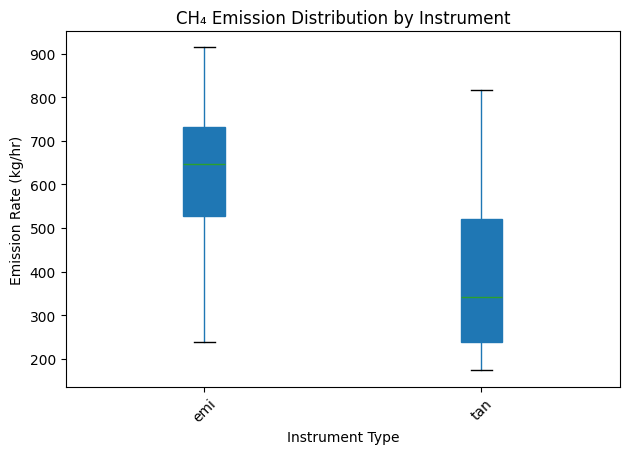

In [40]:
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("myanmar_ch4_plumes.csv")

# Drop missing values
df = df.dropna(subset=["emission_auto", "instrument"])

# Basic boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column="emission_auto", by="instrument", grid=False, patch_artist=True)

plt.title("CH₄ Emission Distribution by Instrument")
plt.suptitle("")  # remove automatic pandas title
plt.xlabel("Instrument Type")
plt.ylabel("Emission Rate (kg/hr)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
